### as part of this connection, we have to determine if the regulatory overlay affects what water source type per water right site
 - i.e., groundwater regulatory overlay versus surface water overlay
 - will have to read in site.csv and watersource.csv from wr data -> determine watersource type per site -> determine watersource type per regulatory overlay area -> assign reUUID to wr site per matching watersource type

In [1]:
# For ID, these need to be groundwater sites only

In [2]:
# old approach
# # plot out polygon
# contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
# ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
# gplt.polyplot(gdf_iscr, ax=ax)

In [3]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# visulizaiton
import missingno as msno # creates a matrix chart to show missing values
import plotly.express as px
import plotly.graph_objects as go # for subplot creation
from plotly.subplots import make_subplots # for subplot creation
import matplotlib.pyplot as mplt # use with gplt to save fig to pdf

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [4]:
# Inputs
#varST = "ID" # state abbreviation
varSTName = "Idaho" # state name
# varUUIDType = "re" # uuid abbreviation
# varWaDEDataType = "Regulatory" # WaDE datatype for file location
# mainInputFile = "Pre_idMain.zip" # use processed zip file

In [5]:
# Working Directory
workingDir = "G:/Shared drives/WaDE Data/" + varSTName + "/Regulatory"
os.chdir(workingDir)

## Input Data

#### wade WR watersources.csv & site.csv data
- convert to geodataframe

In [6]:
# watersources.csv
inputString = "G:/Shared drives/WaDE Data/" + varSTName + "/WaterAllocation/ProcessedInputData/watersources.csv"
dfws = pd.read_csv(inputString)
print(len(dfws))
dfws.head(1)

6715


,WaterSourceUUID,Geometry,GNISFeatureNameCV,WaterQualityIndicatorCV,WaterSourceName,WaterSourceNativeID,WaterSourceTypeCV
0,IDwr_WSwadeID1,NaN,NaN,Fresh,Ground Water,wadeID1,Groundwater


In [7]:
# sites.csv
inputString = "G:/Shared drives/WaDE Data/" + varSTName + "/WaterAllocation/ProcessedInputData/sites.csv"
dfs = pd.read_csv(inputString)
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(len(dfs))
dfs.head(1)

C:\Users\rjame\AppData\Local\Temp\ipykernel_11396\1769133293.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.read_csv(inputString)


463807


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.786783,-116.756335,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater


In [8]:
dfs['WaterSourceTypeCV'].unique()

array(['Groundwater', 'Surface Water', 'Reuse', 'WaDE Unspecified'],
      dtype=object)

In [9]:
# We only want 'Groundwater' records.
dfs['WaterSourceTypeCV'] = dfs['WaterSourceTypeCV'].str.strip()
dfs = dfs[dfs['WaterSourceTypeCV'] == "Groundwater"].reset_index(drop=True) #watersourcetypeCV here
print(len(dfs))
dfs.head(1)

254380


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.786783,-116.756335,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

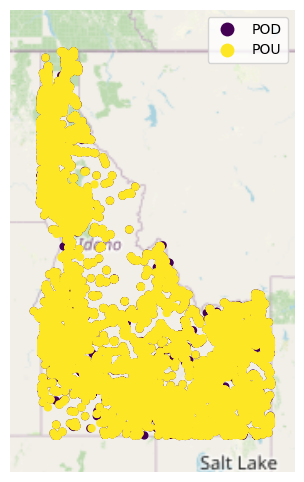

In [10]:
# Map out points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.Longitude.astype(float), dfs.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [11]:
# regulatoryreportingunits.csv data
inputFile = "ProcessedInputData/regulatoryreportingunits.csv"
df_rru = pd.read_csv(inputFile)
print(len(df_rru))
df_rru.head(1)

3


,DataPublicationDate,OrganizationUUID,RegulatoryOverlayUUID,ReportingUnitUUID
0,05/17/2023,IDre_O1,IDre_ROwade1,IDre_RUwade1


In [12]:
# reportingunits.csv data
inputFile = "ProcessedInputData/reportingunits.csv"
dfru = pd.read_csv(inputFile)
print(len(dfru))
dfru.head(1)

3


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,WaDEUUID
0,IDre_RUwade1,4326,Eastern Snake,wade1,NaN,Comprehensive Aquifer Management Plan,NaN,ID,"POLYGON ((-111.677567 44.223037, -111.670541 4...",wade1


# Extract RegulatoryOverlay from Reporting Units and assing to WR Sites

In [13]:
dfru_2 = dfru.copy()
dfru_2 = pd.merge(dfru_2, df_rru[['ReportingUnitUUID', 'RegulatoryOverlayUUID']], left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')
print(len(dfru_2))
dfru_2.head(1)

3


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,WaDEUUID,RegulatoryOverlayUUID
0,IDre_RUwade1,4326,Eastern Snake,wade1,NaN,Comprehensive Aquifer Management Plan,NaN,ID,"POLYGON ((-111.677567 44.223037, -111.670541 4...",wade1,IDre_ROwade1


<GeoAxesSubplot: >

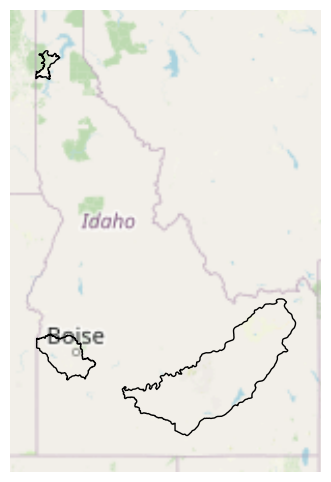

In [14]:
# Convert to geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru_2 = dfru_2[dfru_2['Geometry'] != ""].reset_index(drop=True)
dfru_2['Geometry'] = gpd.GeoSeries.from_wkt(dfru_2['Geometry'], crs="EPSG:4326")
gdfru_2 = gpd.GeoDataFrame(dfru_2, geometry=dfru_2['Geometry'], crs="EPSG:4326") # covert to geodataframe
#gdf_iscr['Geometry'] = gdf_iscr.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.
gplt.polyplot(gdfru_2, ax=ax)

In [15]:
# Select sites within polygon.
gdfs_ru = gpd.sjoin(left_df=gdfs, right_df=gdfru_2[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs_ru))
gdfs.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


133949


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.786783,-116.756335,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater,POINT (-116.75633 46.78678)
1,IDwr_SPOD100116,NaN,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,43.209117,-112.325907,NaN,NaN,POD,WaDE Unspecified,POD100116,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater,POINT (-112.32591 43.20912)
2,IDwr_SPOD100156,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,42.777481,-114.925040,NaN,NaN,POD,WaDE Unspecified,POD100156,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater,POINT (-114.92504 42.77748)
3,IDwr_SPOD100157,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,44.114239,-115.426493,NaN,NaN,POD,WaDE Unspecified,POD100157,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater,POINT (-115.42649 44.11424)
4,IDwr_SPOD100164,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,42.037296,-111.752364,NaN,NaN,POD,WaDE Unspecified,POD100164,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater,POINT (-111.75236 42.03730)


<GeoAxesSubplot: >

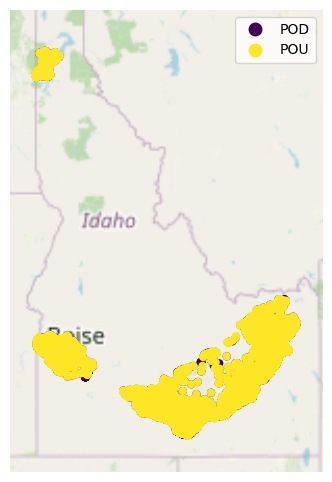

In [16]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs_ru, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [17]:
# set RegulatoryOverlayUUIDs & drop unnecessary sites
gdfs_ru['RegulatoryOverlayUUIDs'] = gdfs_ru['RegulatoryOverlayUUID']
gdfs_ru = gdfs_ru.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
print(len(gdfs_ru))
gdfs_ru.head(1)

133949


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
1,IDwr_SPOD100116,IDre_ROwade1,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.209117,-112.325907,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,


# Merge Dataframes
- drop geometry from the wade wr sites.csv geodataframe

In [19]:
# Concatenate dataframes
gdfs = gdfs.drop(['geometry'], axis=1)
frames = [gdfs, gdfs_ru] # add site dataframes togehter here
outdf = pd.concat(frames)
outdf = outdf.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
print(len(outdf))

388329


In [21]:
# groupby() fields on SiteNativeID
outdf = outdf.groupby('SiteNativeID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem!=''])).replace(np.nan, "").reset_index()
print(len(outdf))
outdf.head(1)

254380


,SiteNativeID,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,POD10001,IDwr_SPOD10001,,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,,,,,46.786783431,-116.756334953,,,POD,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater


# Inspect Output Data & Export

In [22]:
outdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254380 entries, 0 to 254379
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteNativeID            254380 non-null  object
 1   SiteUUID                254380 non-null  object
 2   RegulatoryOverlayUUIDs  254380 non-null  object
 3   WaterSourceUUIDs        254380 non-null  object
 4   CoordinateAccuracy      254380 non-null  object
 5   CoordinateMethodCV      254380 non-null  object
 6   County                  254380 non-null  object
 7   EPSGCodeCV              254380 non-null  object
 8   Geometry                254380 non-null  object
 9   GNISCodeCV              254380 non-null  object
 10  HUC12                   254380 non-null  object
 11  HUC8                    254380 non-null  object
 12  Latitude                254380 non-null  object
 13  Longitude               254380 non-null  object
 14  NHDNetworkStatusCV      254380 non-n

In [23]:
outdf

,SiteNativeID,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,POD10001,IDwr_SPOD10001,,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,,,,,46.786783431,-116.756334953,,,POD,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
1,POD100116,IDwr_SPOD100116,IDre_ROwade1,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.209117477,-112.325906615,,,POD,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
2,POD100156,IDwr_SPOD100156,IDre_ROwade1,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,42.777481293,-114.925039514,,,POD,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
3,POD100157,IDwr_SPOD100157,,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,44.114239357,-115.426493307,,,POD,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
4,POD100164,IDwr_SPOD100164,,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,42.037295784,-111.752364458,,,POD,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254375,POU99965,IDwr_SPOU99965,,IDwr_WSwadeID1,WaDE Unspecified,Centroid,WaDE Unspecified,4326,POLYGON ((-112.92623643499996 42.7044273390000...,,,,42.7040687483,-112.923845261,,,POU,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
254376,POU99968,IDwr_SPOU99968,IDre_ROwade1,IDwr_WSwadeID1,WaDE Unspecified,Centroid,WaDE Unspecified,4326,POLYGON ((-111.96851683099999 43.6409311050000...,,,,43.6405816372,-111.968943133,,,POU,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
254377,POU99976,IDwr_SPOU99976,,IDwr_WSwadeID1,WaDE Unspecified,Centroid,WaDE Unspecified,4326,MULTIPOLYGON (((-116.70654664299997 43.9524236...,,,,43.9531389755,-116.705494872,,,POU,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
254378,POU99982,IDwr_SPOU99982,IDre_ROwade1,IDwr_WSwadeID1,WaDE Unspecified,Centroid,WaDE Unspecified,4326,POLYGON ((-111.90283637999994 43.7972468550000...,,,,43.799064553,-111.905363998,,,POU,WaDE Unspecified,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater


In [24]:
outdf.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder